In [1]:
import pandas as pd
pd.set_option("max_colwidth", 150)
pd.set_option("display.max.columns", None)
pd.set_option("display.max.rows", 20)

import numpy as np
from scipy.stats import pearsonr, pointbiserialr

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
plt.style.use("seaborn-talk")
import matplotlib.ticker as mtick

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
np.seterr(divide='ignore')
warnings.filterwarnings(action='ignore', message='Mean of empty slice')
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
def load_data(file_path, indx = True, indx_col = 0):
  '''Parameters:
  file_path: path to your excel or csv file with data,
  indx: boolean - whether there is index column in your file (usually it is the first column) --> *by default it is set to True
  indx_col: int - if your file has an index column, specify column number here --> *by default it is equal to 0 (first column)
  '''
  if indx == True and file_path.endswith(".xlsx"):
    data = pd.read_excel(file_path, index_col = indx_col)
  elif indx == False and file_path.endswith(".xlsx"):
    data = pd.read_excel(file_path)

  elif indx == True and file_path.endswith(".csv"):
    data = pd.read_csv(file_path, index_col = indx_col)
  elif indx == False and file_path.endswith(".csv"):
    data = pd.read_csv(file_path)

  return data

##Load debate data

In [162]:
merge_all_data_cln = load_data("/content/drive/MyDrive/Colab Notebooks/debates/debata_2020_June_all_DATA.xlsx")
merge_all_data_cln.shape

(150, 112)

In [163]:
merge_all_data_cln = merge_all_data_cln.sort_values(by = "start")
merge_all_data_cln["Time"] = pd.to_datetime(merge_all_data_cln.start)

In [5]:
emotions = ['Anger', 'Sadness', 'Fear', 'Disgust', 'Happiness'] 

cols = [c for c in merge_all_data_cln.columns for i, n in enumerate(emotions) if (emotions[i] in c) and (len(c) < 25)]
cols

['conclusion_Happiness',
 'conclusion_Anger',
 'conclusion_Sadness',
 'conclusion_Fear',
 'conclusion_Disgust',
 'premise_Happiness',
 'premise_Anger',
 'premise_Sadness',
 'premise_Fear',
 'premise_Disgust',
 'full_argument_Happiness',
 'full_argument_Anger',
 'full_argument_Sadness',
 'full_argument_Fear',
 'full_argument_Disgust']

#### Social media reactions

In [164]:
# expressed emotions

social_media = load_data("/content/drive/MyDrive/Colab Notebooks/debates/validation_samples/tweet_Czerwiec_expressed_sentiment.xlsx")
social_media.shape

(35360, 11)

In [165]:
social_media.sort_values(by = 'Data', inplace=True)
social_media.head(2)

,Data,Tekst,clean_Tekst,predicted_emotion_PaREMO,predicted_emotion_label_PaREMO,sentiment_PaRes,sentiment_label_PaRes,predicted_emotion_XLM_tuned,predicted_emotion_label_XLM_tuned,predicted_emotion_PaREMO_2,predicted_emotion_label_PaREMO_2
85331.0,2020-06-17 21:00:00,No to co zaczynamy ten kabaret #debataprezydencka,no to co zaczynamy ten kabaret,4.0,joy,0.0,neg,0.0,neutral,6.0,surprise
85326.0,2020-06-17 21:00:02,Naprzod #DUDA2020 ! Do przodu #DUDA2020 ! #DUDA2020 DAWAJ !! #debataprezydencka,naprzod ! do przodu ! dawaj !!,6.0,surprise,2.0,pos,0.0,neutral,6.0,surprise


In [166]:
social_media["Time"] = social_media["Data"].dt.time.apply(str)
social_media.head(2)

,Data,Tekst,clean_Tekst,predicted_emotion_PaREMO,predicted_emotion_label_PaREMO,sentiment_PaRes,sentiment_label_PaRes,predicted_emotion_XLM_tuned,predicted_emotion_label_XLM_tuned,predicted_emotion_PaREMO_2,predicted_emotion_label_PaREMO_2,Time
85331.0,2020-06-17 21:00:00,No to co zaczynamy ten kabaret #debataprezydencka,no to co zaczynamy ten kabaret,4.0,joy,0.0,neg,0.0,neutral,6.0,surprise,21:00:00
85326.0,2020-06-17 21:00:02,Naprzod #DUDA2020 ! Do przodu #DUDA2020 ! #DUDA2020 DAWAJ !! #debataprezydencka,naprzod ! do przodu ! dawaj !!,6.0,surprise,2.0,pos,0.0,neutral,6.0,surprise,21:00:02


####Functions preprocess

In [ ]:
def process_reactions(dataframe_social_media, dataframe_debate, analysis_type = "sentiment"):
  """
  shift = -1 and rolling average = 2 minutes;
  
  function arguments: 
  dataframe: data with social media reactions (comments), 

  analysis_type: 'sentiment' or 'emotions', 

  """
  sm_data = dataframe_social_media.copy()
  deb_data = dataframe_debate.copy()

  sm_data.sort_values(by = 'Data', inplace=True)

  # eliciting emotions
  deb_data["Time"] = pd.to_datetime(deb_data.start)
  deb_data.sort_values(by = "Time", inplace=True)
  df_plot = deb_data.set_index("Time").resample("1T").mean().fillna(0)
  df_plot.reset_index(inplace=True)
  df_plot["Time"] = df_plot["Time"].dt.time.apply(str)

  if analysis_type == "emotion":
    df_plots_counts_normalized = pd.DataFrame(sm_data.set_index("Data").shift(periods=-1, 
                                                                              freq="T", 
                                                                              axis=0).resample("1T")["predicted_emotion_label_PaREMO"].value_counts(normalize=True)) * 100
    df_plots_counts_normalized.columns = ['_'.join(col) for col in df_plots_counts_normalized.columns]
    df_plots_counts_normalized = df_plots_counts_normalized.reset_index()
    df_plots_counts_normalized.columns = ['Data', 'predicted_emotion_label_PaREMO', 'mean']

    # rolling sm
    df_plots_counts_normalized_f = df_plots_counts_normalized[df_plots_counts_normalized.predicted_emotion_label_PaREMO == "fear"]
    df_plots_counts_normalized_h = df_plots_counts_normalized[df_plots_counts_normalized.predicted_emotion_label_PaREMO == "joy"]
    df_plots_counts_normalized_a = df_plots_counts_normalized[df_plots_counts_normalized.predicted_emotion_label_PaREMO == "anger"]
    df_plots_counts_normalized_su = df_plots_counts_normalized[df_plots_counts_normalized.predicted_emotion_label_PaREMO == "surprise"]
    df_plots_counts_normalized_sa = df_plots_counts_normalized[df_plots_counts_normalized.predicted_emotion_label_PaREMO == "sadness"]
    df_plots_counts_normalized_d = df_plots_counts_normalized[df_plots_counts_normalized.predicted_emotion_label_PaREMO == "disgust"]

    df_plots_counts_normalized_f = df_plots_counts_normalized_f.set_index("Data").rolling('2min').mean().reset_index()
    df_plots_counts_normalized_f['predicted_emotion_label_PaREMO'] = 'fear'

    df_plots_counts_normalized_h = df_plots_counts_normalized_h.set_index("Data").rolling('2min').mean().reset_index()
    df_plots_counts_normalized_h['predicted_emotion_label_PaREMO'] = 'joy'

    df_plots_counts_normalized_a = df_plots_counts_normalized_a.set_index("Data").rolling('2min').mean().reset_index()
    df_plots_counts_normalized_a['predicted_emotion_label_PaREMO'] = 'anger'

    df_plots_counts_normalized_su = df_plots_counts_normalized_su.set_index("Data").rolling('2min').mean().reset_index()
    df_plots_counts_normalized_su['predicted_emotion_label_PaREMO'] = 'surprise'

    df_plots_counts_normalized_sa = df_plots_counts_normalized_sa.set_index("Data").rolling('2min').mean().reset_index()
    df_plots_counts_normalized_sa['predicted_emotion_label_PaREMO'] = 'sadness'

    df_plots_counts_normalized_d = df_plots_counts_normalized_d.set_index("Data").rolling('2min').mean().reset_index()
    df_plots_counts_normalized_d['predicted_emotion_label_PaREMO'] = 'disgust'

    df_plots_counts_normalized = pd.concat([df_plots_counts_normalized_f, 
                                        df_plots_counts_normalized_h, 
                                        df_plots_counts_normalized_a, 
                                        df_plots_counts_normalized_su, 
                                        df_plots_counts_normalized_sa, 
                                        df_plots_counts_normalized_d], axis=0)
    df_plots_counts_normalized.sort_values(by = ['Data', 'predicted_emotion_label_PaREMO'], inplace=True)
    df_plots_counts_normalized["Time"] = df_plots_counts_normalized["Data"].dt.time.apply(str)
    df_plot_join = pd.merge(df_plots_counts_normalized, df_plot, on = "Time", how = "left")

    emotions = ['Anger', 'Sadness', 'Fear', 'Disgust', 'Happiness'] # nrc like
    cols = [c for c in df_plot_join.columns for i, n in enumerate(emotions) if emotions[i] in c]
    
    # elicited emotions baselines
    elicited_emo_baselines = df_plot[cols].describe().round(2)
    elicited_emo_baselines = pd.DataFrame(elicited_emo_baselines.loc["mean"]).T
    df_baselines_diff = df_plot_join.copy()
    for col in elicited_emo_baselines.columns:
      df_baselines_diff[col] = df_plot_join[col] - elicited_emo_baselines[col].iloc[0]
    
    # expressed emotions baselines
    expressed_emo_baselines = pd.DataFrame(df_plot_join.groupby("predicted_emotion_label_PaREMO")["mean"].mean()).reset_index()
    expressed_emo_baselines = expressed_emo_baselines.set_index("predicted_emotion_label_PaREMO").T
    for col in set(expressed_emo_baselines.columns):
      ids = df_baselines_diff[df_baselines_diff.predicted_emotion_label_PaREMO == col]["mean"].index
      df_baselines_diff.loc[ids, "mean"] = df_baselines_diff.loc[ids, "mean"] - expressed_emo_baselines[col].iloc[0]


  else:
    df_plots_counts_normalized = pd.DataFrame(sm_data.set_index("Data").shift(periods=-1, 
                                                                              freq="T", 
                                                                              axis=0).resample("1T")["sentiment_label_PaRes"].value_counts(normalize=True)) * 100
    df_plots_counts_normalized.columns = ['_'.join(col) for col in df_plots_counts_normalized.columns]
    df_plots_counts_normalized = df_plots_counts_normalized.reset_index()
    df_plots_counts_normalized.columns = ['Data', 'sentiment_label_PaRes', 'mean']

    # rolling
    df_plots_counts_normalized_neu = df_plots_counts_normalized[df_plots_counts_normalized.sentiment_label_PaRes == "neu"]
    df_plots_counts_normalized_neg = df_plots_counts_normalized[df_plots_counts_normalized.sentiment_label_PaRes == "neg"]
    df_plots_counts_normalized_pos = df_plots_counts_normalized[df_plots_counts_normalized.sentiment_label_PaRes == "pos"]

    df_plots_counts_normalized_pos = df_plots_counts_normalized_pos.set_index("Data").rolling('2min').mean().reset_index()
    df_plots_counts_normalized_pos['sentiment_label_PaRes'] = 'pos'
    df_plots_counts_normalized_neg = df_plots_counts_normalized_neg.set_index("Data").rolling('2min').mean().reset_index()
    df_plots_counts_normalized_neg['sentiment_label_PaRes'] = 'neg'
    df_plots_counts_normalized_neu = df_plots_counts_normalized_neu.set_index("Data").rolling('2min').mean().reset_index()
    df_plots_counts_normalized_neu['sentiment_label_PaRes'] = 'neu'

    df_plots_counts_normalized = pd.concat([df_plots_counts_normalized_neu, 
                                        df_plots_counts_normalized_neg, 
                                        df_plots_counts_normalized_pos], 
                                       axis=0)
    df_plots_counts_normalized.sort_values(by = ['Data', 'sentiment_label_PaRes'], inplace=True)
    df_plots_counts_normalized["Time"] = df_plots_counts_normalized["Data"].dt.time.apply(str)
    
    # merge social media and debate data
    df_plot_join = pd.merge(df_plots_counts_normalized, df_plot, on = "Time", how = "left")
    
    cols2 = ['conclusion_Negative_percentage', 'conclusion_Positive_percentage',
             'premise_Negative_percentage','premise_Positive_percentage','conclusion_valence_negative',
             'conclusion_valence_positive','premise_valence_negative','premise_valence_positive',
             'mean_neg','mean_neu','mean_pos','full_argument_Negative_percentage','full_argument_Positive_percentage',
             'full_argument_valence_negative','full_argument_valence_positive']
    df_plot_join = df_plot_join[['Data', 'mean', 'sentiment_label_PaRes', 'Time']+cols2]

    # elicited valence baselines
    elicited_val_baselines = df_plot[cols2].describe().round(2)
    elicited_val_baselines = pd.DataFrame(elicited_val_baselines.loc["mean"]).T    
    print(elicited_val_baselines) 
    df_baselines_diff = df_plot_join.copy()
    for col in elicited_val_baselines.columns:
      df_baselines_diff[col] = df_plot_join[col] - elicited_val_baselines[col].iloc[0]
    
    # expressed sentiment baselines
    expressed_senti_baselines = pd.DataFrame(df_plot_join.groupby("sentiment_label_PaRes")["mean"].mean()).reset_index()
    expressed_senti_baselines = expressed_senti_baselines.set_index("sentiment_label_PaRes").T
    for col in set(expressed_senti_baselines.columns):
      ids = df_baselines_diff[df_baselines_diff.sentiment_label_PaRes == col]["mean"].index
      df_baselines_diff.loc[ids, "mean"] = df_baselines_diff.loc[ids, "mean"] - expressed_senti_baselines[col].iloc[0]

  return df_baselines_diff


In [ ]:
def process_reactions_noroll(dataframe_social_media, dataframe_debate, analysis_type = "sentiment"):
  """
  shift = -1 ;
  
  function arguments: 
  dataframe: data with social media reactions (comments), 

  analysis_type: 'sentiment' or 'emotions', 

  """
  sm_data = dataframe_social_media.copy()
  deb_data = dataframe_debate.copy()

  sm_data.sort_values(by = 'Data', inplace=True)

  # eliciting emotions
  deb_data["Time"] = pd.to_datetime(deb_data.start)
  deb_data.sort_values(by = "Time", inplace=True)
  df_plot = deb_data.set_index("Time").resample("1T").mean().fillna(0)
  df_plot.reset_index(inplace=True)
  df_plot["Time"] = df_plot["Time"].dt.time.apply(str)

  if analysis_type == "emotion":
    df_plots_counts_normalized = pd.DataFrame(sm_data.set_index("Data").shift(periods=-1, 
                                                                              freq="T", 
                                                                              axis=0).resample("1T")["predicted_emotion_label_PaREMO"].value_counts(normalize=True)) * 100
    df_plots_counts_normalized.columns = ['_'.join(col) for col in df_plots_counts_normalized.columns]
    df_plots_counts_normalized = df_plots_counts_normalized.reset_index()
    df_plots_counts_normalized.columns = ['Data', 'predicted_emotion_label_PaREMO', 'mean']

    df_plots_counts_normalized.sort_values(by = ['Data', 'predicted_emotion_label_PaREMO'], inplace=True)
    df_plots_counts_normalized["Time"] = df_plots_counts_normalized["Data"].dt.time.apply(str)
    df_plot_join = pd.merge(df_plots_counts_normalized, df_plot, on = "Time", how = "left")

    emotions = ['Anger', 'Sadness', 'Fear', 'Disgust', 'Happiness'] # nrc like
    cols = [c for c in df_plot_join.columns for i, n in enumerate(emotions) if emotions[i] in c]
    
    # elicited emotions baselines
    elicited_emo_baselines = df_plot[cols].describe().round(2)
    elicited_emo_baselines = pd.DataFrame(elicited_emo_baselines.loc["mean"]).T
    df_baselines_diff = df_plot_join.copy()
    for col in elicited_emo_baselines.columns:
      df_baselines_diff[col] = df_plot_join[col] - elicited_emo_baselines[col].iloc[0]
    
    # expressed emotions baselines
    expressed_emo_baselines = pd.DataFrame(df_plot_join.groupby("predicted_emotion_label_PaREMO")["mean"].mean()).reset_index()
    expressed_emo_baselines = expressed_emo_baselines.set_index("predicted_emotion_label_PaREMO").T
    for col in set(expressed_emo_baselines.columns):
      ids = df_baselines_diff[df_baselines_diff.predicted_emotion_label_PaREMO == col]["mean"].index
      df_baselines_diff.loc[ids, "mean"] = df_baselines_diff.loc[ids, "mean"] - expressed_emo_baselines[col].iloc[0]


  else:
    df_plots_counts_normalized = pd.DataFrame(sm_data.set_index("Data").shift(periods=-1, 
                                                                              freq="T", 
                                                                              axis=0).resample("1T")["sentiment_label_PaRes"].value_counts(normalize=True)) * 100
    df_plots_counts_normalized.columns = ['_'.join(col) for col in df_plots_counts_normalized.columns]
    df_plots_counts_normalized = df_plots_counts_normalized.reset_index()
    df_plots_counts_normalized.columns = ['Data', 'sentiment_label_PaRes', 'mean']

    df_plots_counts_normalized.sort_values(by = ['Data', 'sentiment_label_PaRes'], inplace=True)
    df_plots_counts_normalized["Time"] = df_plots_counts_normalized["Data"].dt.time.apply(str)
    
    # merge social media and debate data
    df_plot_join = pd.merge(df_plots_counts_normalized, df_plot, on = "Time", how = "left")
    
    cols2 = ['conclusion_Negative_percentage', 'conclusion_Positive_percentage',
             'premise_Negative_percentage','premise_Positive_percentage','conclusion_valence_negative',
             'conclusion_valence_positive','premise_valence_negative','premise_valence_positive',
             'mean_neg','mean_neu','mean_pos','full_argument_Negative_percentage','full_argument_Positive_percentage',
             'full_argument_valence_negative','full_argument_valence_positive']
    df_plot_join = df_plot_join[['Data', 'mean', 'sentiment_label_PaRes', 'Time']+cols2]

    # elicited valence baselines
    elicited_val_baselines = df_plot[cols2].describe().round(2)
    elicited_val_baselines = pd.DataFrame(elicited_val_baselines.loc["mean"]).T    
    print(elicited_val_baselines) 
    df_baselines_diff = df_plot_join.copy()
    for col in elicited_val_baselines.columns:
      df_baselines_diff[col] = df_plot_join[col] - elicited_val_baselines[col].iloc[0]
    
    # expressed sentiment baselines
    expressed_senti_baselines = pd.DataFrame(df_plot_join.groupby("sentiment_label_PaRes")["mean"].mean()).reset_index()
    expressed_senti_baselines = expressed_senti_baselines.set_index("sentiment_label_PaRes").T
    for col in set(expressed_senti_baselines.columns):
      ids = df_baselines_diff[df_baselines_diff.sentiment_label_PaRes == col]["mean"].index
      df_baselines_diff.loc[ids, "mean"] = df_baselines_diff.loc[ids, "mean"] - expressed_senti_baselines[col].iloc[0]

  return df_baselines_diff

In [9]:
def process_reactions_nobase(dataframe_social_media, dataframe_debate, analysis_type = "sentiment"):
  """
  shift = -1 ;
  
  function arguments: 
  dataframe: data with social media reactions (comments), 

  analysis_type: 'sentiment' or 'emotions', 

  """
  schems_arg = ['scheme_name_Causal Slippery Slope', 'scheme_name_Danger Appeal',
       'scheme_name_Fear Appeal', 'scheme_name_Need For Help', 
       'scheme_name_Negative Consequences', 
       'scheme_name_Positive Consequences', 'scheme_name_Waste']
  sm_data = dataframe_social_media.copy()
  deb_data = dataframe_debate.copy()

  sm_data.sort_values(by = 'Data', inplace=True)

  # eliciting emotions
  deb_data["Time"] = pd.to_datetime(deb_data.start)
  deb_data.sort_values(by = "Time", inplace=True)
  df_plot = deb_data.set_index("Time").resample("1T").mean().fillna(0)
  df_plot.reset_index(inplace=True)
  df_plot["Time"] = df_plot["Time"].dt.time.apply(str)

  if analysis_type == "emotion":
    df_plots_counts_normalized = pd.DataFrame(sm_data.set_index("Data").shift(periods=-1, 
                                                                              freq="T", 
                                                                              axis=0).resample("1T")["predicted_emotion_label_PaREMO"].value_counts(normalize=True)) * 100
    df_plots_counts_normalized.columns = ['_'.join(col) for col in df_plots_counts_normalized.columns]
    df_plots_counts_normalized = df_plots_counts_normalized.reset_index()
    df_plots_counts_normalized.columns = ['Data', 'predicted_emotion_label_PaREMO', 'mean']

    df_plots_counts_normalized.sort_values(by = ['Data', 'predicted_emotion_label_PaREMO'], inplace=True)
    df_plots_counts_normalized["Time"] = df_plots_counts_normalized["Data"].dt.time.apply(str)
    df_plot_join = pd.merge(df_plots_counts_normalized, df_plot, on = "Time", how = "left")

    emotions = ['Anger', 'Sadness', 'Fear', 'Disgust', 'Happiness'] # nrc like
    cols = [c for c in df_plot_join.columns for i, n in enumerate(emotions) if emotions[i] in c]
    

    df_baselines_diff = df_plot_join.copy()

    
    # expressed emotions baselines
    expressed_emo_baselines = pd.DataFrame(df_plot_join.groupby("predicted_emotion_label_PaREMO")["mean"].mean()).reset_index()
    expressed_emo_baselines = expressed_emo_baselines.set_index("predicted_emotion_label_PaREMO").T
    print(f"Baseline values: \n{expressed_emo_baselines} ")
    for col in set(expressed_emo_baselines.columns):
      ids = df_baselines_diff[df_baselines_diff.predicted_emotion_label_PaREMO == col]["mean"].index
      df_baselines_diff.loc[ids, "mean"] = df_baselines_diff.loc[ids, "mean"] - expressed_emo_baselines[col].iloc[0]


  else:
    df_plots_counts_normalized = pd.DataFrame(sm_data.set_index("Data").shift(periods=-1, 
                                                                              freq="T", 
                                                                              axis=0).resample("1T")["sentiment_label_PaRes"].value_counts(normalize=True)) * 100
    df_plots_counts_normalized.columns = ['_'.join(col) for col in df_plots_counts_normalized.columns]
    df_plots_counts_normalized = df_plots_counts_normalized.reset_index()
    df_plots_counts_normalized.columns = ['Data', 'sentiment_label_PaRes', 'mean']

    df_plots_counts_normalized.sort_values(by = ['Data', 'sentiment_label_PaRes'], inplace=True)
    df_plots_counts_normalized["Time"] = df_plots_counts_normalized["Data"].dt.time.apply(str)
    
    # merge social media and debate data
    df_plot_join = pd.merge(df_plots_counts_normalized, df_plot, on = "Time", how = "left")
    
    cols2 = ['conclusion_Negative_percentage', 'conclusion_Positive_percentage',
             'premise_Negative_percentage','premise_Positive_percentage','conclusion_valence_negative',
             'conclusion_valence_positive','premise_valence_negative','premise_valence_positive',
             'mean_neg','mean_neu','mean_pos','full_argument_Negative_percentage','full_argument_Positive_percentage',
             'full_argument_valence_negative','full_argument_valence_positive'] + schems_arg
    df_plot_join = df_plot_join[['Data', 'mean', 'sentiment_label_PaRes', 'Time']+cols2]

    # elicited valence 
    df_baselines_diff = df_plot_join.copy()
    
    # expressed sentiment baselines
    expressed_senti_baselines = pd.DataFrame(df_plot_join.groupby("sentiment_label_PaRes")["mean"].mean()).reset_index()
    expressed_senti_baselines = expressed_senti_baselines.set_index("sentiment_label_PaRes").T
    print(f"Baseline values: \n{expressed_senti_baselines} ")

    for col in set(expressed_senti_baselines.columns):
      ids = df_baselines_diff[df_baselines_diff.sentiment_label_PaRes == col]["mean"].index
      df_baselines_diff.loc[ids, "mean"] = df_baselines_diff.loc[ids, "mean"] - expressed_senti_baselines[col].iloc[0]

  return df_baselines_diff

In [10]:
def process_reactions_nobase_ver2(dataframe_social_media, dataframe_debate, analysis_type = "sentiment"):
  """
  shift = -1 ;
  
  function arguments: 
  dataframe: data with social media reactions (comments), 

  analysis_type: 'sentiment' or 'emotions', 

  """
  schems_arg = ['scheme_name_Causal Slippery Slope', 'scheme_name_Danger Appeal',
       'scheme_name_Fear Appeal', 'scheme_name_Need For Help', 
       'scheme_name_Negative Consequences', 
       'scheme_name_Positive Consequences', 'scheme_name_Waste']
  sm_data = dataframe_social_media.copy()
  deb_data = dataframe_debate.copy()

  sm_data.sort_values(by = 'Data', inplace=True)

  # eliciting emotions
  deb_data["Time"] = pd.to_datetime(deb_data.start)
  deb_data.sort_values(by = "Time", inplace=True)
  df_plot = deb_data.set_index("Time").resample("1T").mean().fillna(0)
  df_plot.reset_index(inplace=True)
  df_plot["Time"] = df_plot["Time"].dt.time.apply(str)

  if analysis_type == "emotion":
    df_plots_counts_normalized = pd.DataFrame(sm_data.set_index("Data").shift(periods=-1, 
                                                                              freq="T", 
                                                                              axis=0).resample("1T")["predicted_emotion_label_PaREMO"].value_counts(normalize=True)) * 100
    df_plots_counts_normalized.columns = ['_'.join(col) for col in df_plots_counts_normalized.columns]
    df_plots_counts_normalized = df_plots_counts_normalized.reset_index()
    df_plots_counts_normalized.columns = ['Data', 'predicted_emotion_label_PaREMO', 'mean']

    df_plots_counts_normalized.sort_values(by = ['Data', 'predicted_emotion_label_PaREMO'], inplace=True)
    df_plots_counts_normalized["Time"] = df_plots_counts_normalized["Data"].dt.time.apply(str)
    df_plot_join = pd.merge(df_plots_counts_normalized, df_plot, on = "Time", how = "left")

    emotions = ['Anger', 'Sadness', 'Fear', 'Disgust', 'Happiness'] # nrc like
    cols = [c for c in df_plot_join.columns for i, n in enumerate(emotions) if emotions[i] in c]
    

    df_baselines_diff = df_plot_join.copy()

    
    # expressed emotions baselines
    expressed_emo_baselines = pd.DataFrame(df_plot_join.groupby("predicted_emotion_label_PaREMO")["mean"].mean()).reset_index()
    expressed_emo_baselines = expressed_emo_baselines.set_index("predicted_emotion_label_PaREMO").T
    print(f"Baseline values: \n{expressed_emo_baselines} ")
    for col in set(expressed_emo_baselines.columns):
      ids = df_baselines_diff[df_baselines_diff.predicted_emotion_label_PaREMO == col]["mean"].index
      df_baselines_diff.loc[ids, "mean"] = ((df_baselines_diff.loc[ids, "mean"] / expressed_emo_baselines[col].iloc[0]) * 100) - 100


  else:
    df_plots_counts_normalized = pd.DataFrame(sm_data.set_index("Data").shift(periods=-1, 
                                                                              freq="T", 
                                                                              axis=0).resample("1T")["sentiment_label_PaRes"].value_counts(normalize=True)) * 100
    df_plots_counts_normalized.columns = ['_'.join(col) for col in df_plots_counts_normalized.columns]
    df_plots_counts_normalized = df_plots_counts_normalized.reset_index()
    df_plots_counts_normalized.columns = ['Data', 'sentiment_label_PaRes', 'mean']

    df_plots_counts_normalized.sort_values(by = ['Data', 'sentiment_label_PaRes'], inplace=True)
    df_plots_counts_normalized["Time"] = df_plots_counts_normalized["Data"].dt.time.apply(str)
    
    # merge social media and debate data
    df_plot_join = pd.merge(df_plots_counts_normalized, df_plot, on = "Time", how = "left")
    
    cols2 = ['conclusion_Negative_percentage', 'conclusion_Positive_percentage',
             'premise_Negative_percentage','premise_Positive_percentage','conclusion_valence_negative',
             'conclusion_valence_positive','premise_valence_negative','premise_valence_positive',
             'mean_neg','mean_neu','mean_pos','full_argument_Negative_percentage','full_argument_Positive_percentage',
             'full_argument_valence_negative','full_argument_valence_positive'] + schems_arg
    df_plot_join = df_plot_join[['Data', 'mean', 'sentiment_label_PaRes', 'Time']+cols2]

    # elicited valence 
    df_baselines_diff = df_plot_join.copy()
    
    # expressed sentiment baselines
    expressed_senti_baselines = pd.DataFrame(df_plot_join.groupby("sentiment_label_PaRes")["mean"].mean()).reset_index()
    expressed_senti_baselines = expressed_senti_baselines.set_index("sentiment_label_PaRes").T
    print(f"Baseline values: \n{expressed_senti_baselines} ")

    for col in set(expressed_senti_baselines.columns):
      ids = df_baselines_diff[df_baselines_diff.sentiment_label_PaRes == col]["mean"].index
      df_baselines_diff.loc[ids, "mean"] = ((df_baselines_diff.loc[ids, "mean"] / expressed_senti_baselines[col].iloc[0]) * 100) - 100

  return df_baselines_diff

In [11]:
def process_reactions_nobase_both(dataframe_social_media, dataframe_debate, analysis_type = "sentiment"):
  """
  shift = -1 ;
  
  function arguments: 
  dataframe: data with social media reactions (comments), 

  analysis_type: 'sentiment' or 'emotions', 

  """
  schems_arg = ['scheme_name_Causal Slippery Slope', 'scheme_name_Danger Appeal',
       'scheme_name_Fear Appeal', 'scheme_name_Need For Help', 
       'scheme_name_Negative Consequences', 
       'scheme_name_Positive Consequences', 'scheme_name_Waste']
  sm_data = dataframe_social_media.copy()
  deb_data = dataframe_debate.copy()

  sm_data.sort_values(by = 'Data', inplace=True)

  # eliciting emotions
  deb_data["Time"] = pd.to_datetime(deb_data.start)
  deb_data.sort_values(by = "Time", inplace=True)
  df_plot = deb_data.set_index("Time").resample("1T").mean().fillna(0)
  df_plot.reset_index(inplace=True)
  df_plot["Time"] = df_plot["Time"].dt.time.apply(str)

  if analysis_type == "emotion":
    df_plots_counts_normalized = pd.DataFrame(sm_data.set_index("Data").shift(periods=-1, 
                                                                              freq="T", 
                                                                              axis=0).resample("1T")["predicted_emotion_label_PaREMO"].value_counts(normalize=True)) * 100
    df_plots_counts_normalized.columns = ['_'.join(col) for col in df_plots_counts_normalized.columns]
    df_plots_counts_normalized = df_plots_counts_normalized.reset_index()
    df_plots_counts_normalized.columns = ['Data', 'predicted_emotion_label_PaREMO', 'mean']

    df_plots_counts_normalized.sort_values(by = ['Data', 'predicted_emotion_label_PaREMO'], inplace=True)
    df_plots_counts_normalized["Time"] = df_plots_counts_normalized["Data"].dt.time.apply(str)
    df_plot_join = pd.merge(df_plots_counts_normalized, df_plot, on = "Time", how = "left")

    emotions = ['Anger', 'Sadness', 'Fear', 'Disgust', 'Happiness'] # nrc like
    cols = [c for c in df_plot_join.columns for i, n in enumerate(emotions) if emotions[i] in c]
    

    df_baselines_diff = df_plot_join.copy()


  else:
    df_plots_counts_normalized = pd.DataFrame(sm_data.set_index("Data").shift(periods=-1, 
                                                                              freq="T", 
                                                                              axis=0).resample("1T")["sentiment_label_PaRes"].value_counts(normalize=True)) * 100
    df_plots_counts_normalized.columns = ['_'.join(col) for col in df_plots_counts_normalized.columns]
    df_plots_counts_normalized = df_plots_counts_normalized.reset_index()
    df_plots_counts_normalized.columns = ['Data', 'sentiment_label_PaRes', 'mean']

    df_plots_counts_normalized.sort_values(by = ['Data', 'sentiment_label_PaRes'], inplace=True)
    df_plots_counts_normalized["Time"] = df_plots_counts_normalized["Data"].dt.time.apply(str)
    
    # merge social media and debate data
    df_plot_join = pd.merge(df_plots_counts_normalized, df_plot, on = "Time", how = "left")
    
    cols2 = ['conclusion_Negative_percentage', 'conclusion_Positive_percentage',
             'premise_Negative_percentage','premise_Positive_percentage','conclusion_valence_negative',
             'conclusion_valence_positive','premise_valence_negative','premise_valence_positive',
             'mean_neg','mean_neu','mean_pos','full_argument_Negative_percentage','full_argument_Positive_percentage',
             'full_argument_valence_negative','full_argument_valence_positive'] + schems_arg
    df_plot_join = df_plot_join[['Data', 'mean', 'sentiment_label_PaRes', 'Time']+cols2]

    # elicited valence 
    df_baselines_diff = df_plot_join.copy()
    

  return df_baselines_diff

In [12]:
def process_reactions_nobase2(dataframe_social_media, dataframe_debate, analysis_type = "sentiment"):
  """
  shift = -1 and rolling average = 2 minutes;
  
  function arguments: 
  dataframe: data with social media reactions (comments), 

  analysis_type: 'sentiment' or 'emotions', 

  """
  sm_data = dataframe_social_media.copy()
  deb_data = dataframe_debate.copy()

  sm_data.sort_values(by = 'Data', inplace=True)

  # eliciting emotions
  deb_data["Time"] = pd.to_datetime(deb_data.start)
  deb_data.sort_values(by = "Time", inplace=True)
  df_plot = deb_data.set_index("Time").resample("1T").mean().fillna(0)
  df_plot.reset_index(inplace=True)
  df_plot["Time"] = df_plot["Time"].dt.time.apply(str)

  if analysis_type == "emotion":
    df_plots_counts_normalized = pd.DataFrame(sm_data.set_index("Data").resample("1T")["predicted_emotion_label_PaREMO"].value_counts(normalize=True)) * 100
    df_plots_counts_normalized.columns = ['_'.join(col) for col in df_plots_counts_normalized.columns]
    df_plots_counts_normalized = df_plots_counts_normalized.reset_index()
    df_plots_counts_normalized.columns = ['Data', 'predicted_emotion_label_PaREMO', 'mean']

    # rolling sm
    df_plots_counts_normalized_f = df_plots_counts_normalized[df_plots_counts_normalized.predicted_emotion_label_PaREMO == "fear"]
    df_plots_counts_normalized_h = df_plots_counts_normalized[df_plots_counts_normalized.predicted_emotion_label_PaREMO == "joy"]
    df_plots_counts_normalized_a = df_plots_counts_normalized[df_plots_counts_normalized.predicted_emotion_label_PaREMO == "anger"]
    df_plots_counts_normalized_su = df_plots_counts_normalized[df_plots_counts_normalized.predicted_emotion_label_PaREMO == "surprise"]
    df_plots_counts_normalized_sa = df_plots_counts_normalized[df_plots_counts_normalized.predicted_emotion_label_PaREMO == "sadness"]
    df_plots_counts_normalized_d = df_plots_counts_normalized[df_plots_counts_normalized.predicted_emotion_label_PaREMO == "disgust"]

    df_plots_counts_normalized_f = df_plots_counts_normalized_f.set_index("Data").rolling('2min').mean().reset_index()
    df_plots_counts_normalized_f['predicted_emotion_label_PaREMO'] = 'fear'

    df_plots_counts_normalized_h = df_plots_counts_normalized_h.set_index("Data").rolling('2min').mean().reset_index()
    df_plots_counts_normalized_h['predicted_emotion_label_PaREMO'] = 'joy'

    df_plots_counts_normalized_a = df_plots_counts_normalized_a.set_index("Data").rolling('2min').mean().reset_index()
    df_plots_counts_normalized_a['predicted_emotion_label_PaREMO'] = 'anger'

    df_plots_counts_normalized_su = df_plots_counts_normalized_su.set_index("Data").rolling('2min').mean().reset_index()
    df_plots_counts_normalized_su['predicted_emotion_label_PaREMO'] = 'surprise'

    df_plots_counts_normalized_sa = df_plots_counts_normalized_sa.set_index("Data").rolling('2min').mean().reset_index()
    df_plots_counts_normalized_sa['predicted_emotion_label_PaREMO'] = 'sadness'

    df_plots_counts_normalized_d = df_plots_counts_normalized_d.set_index("Data").rolling('2min').mean().reset_index()
    df_plots_counts_normalized_d['predicted_emotion_label_PaREMO'] = 'disgust'

    df_plots_counts_normalized = pd.concat([df_plots_counts_normalized_f, 
                                        df_plots_counts_normalized_h, 
                                        df_plots_counts_normalized_a, 
                                        df_plots_counts_normalized_su, 
                                        df_plots_counts_normalized_sa, 
                                        df_plots_counts_normalized_d], axis=0)
    df_plots_counts_normalized.sort_values(by = ['Data', 'predicted_emotion_label_PaREMO'], inplace=True)
    df_plots_counts_normalized["Time"] = df_plots_counts_normalized["Data"].dt.time.apply(str)
    df_plot_join = pd.merge(df_plots_counts_normalized, df_plot, on = "Time", how = "left")

    emotions = ['Anger', 'Sadness', 'Fear', 'Disgust', 'Happiness'] # nrc like
    cols = [c for c in df_plot_join.columns for i, n in enumerate(emotions) if emotions[i] in c]
    
    # elicited emotions baselines
    df_baselines_diff = df_plot_join.copy()

    # expressed emotions baselines
    expressed_emo_baselines = pd.DataFrame(df_plot_join.groupby("predicted_emotion_label_PaREMO")["mean"].mean()).reset_index()
    expressed_emo_baselines = expressed_emo_baselines.set_index("predicted_emotion_label_PaREMO").T
    for col in set(expressed_emo_baselines.columns):
      ids = df_baselines_diff[df_baselines_diff.predicted_emotion_label_PaREMO == col]["mean"].index
      df_baselines_diff.loc[ids, "mean"] = df_baselines_diff.loc[ids, "mean"] - expressed_emo_baselines[col].iloc[0]


  else:
    df_plots_counts_normalized = pd.DataFrame(sm_data.set_index("Data").resample("1T")["sentiment_label_PaRes"].value_counts(normalize=True)) * 100
    df_plots_counts_normalized.columns = ['_'.join(col) for col in df_plots_counts_normalized.columns]
    df_plots_counts_normalized = df_plots_counts_normalized.reset_index()
    df_plots_counts_normalized.columns = ['Data', 'sentiment_label_PaRes', 'mean']

    # rolling
    df_plots_counts_normalized_neu = df_plots_counts_normalized[df_plots_counts_normalized.sentiment_label_PaRes == "neu"]
    df_plots_counts_normalized_neg = df_plots_counts_normalized[df_plots_counts_normalized.sentiment_label_PaRes == "neg"]
    df_plots_counts_normalized_pos = df_plots_counts_normalized[df_plots_counts_normalized.sentiment_label_PaRes == "pos"]

    df_plots_counts_normalized_pos = df_plots_counts_normalized_pos.set_index("Data").rolling('2min').mean().reset_index()
    df_plots_counts_normalized_pos['sentiment_label_PaRes'] = 'pos'
    df_plots_counts_normalized_neg = df_plots_counts_normalized_neg.set_index("Data").rolling('2min').mean().reset_index()
    df_plots_counts_normalized_neg['sentiment_label_PaRes'] = 'neg'
    df_plots_counts_normalized_neu = df_plots_counts_normalized_neu.set_index("Data").rolling('2min').mean().reset_index()
    df_plots_counts_normalized_neu['sentiment_label_PaRes'] = 'neu'

    df_plots_counts_normalized = pd.concat([df_plots_counts_normalized_neu, 
                                        df_plots_counts_normalized_neg, 
                                        df_plots_counts_normalized_pos], 
                                       axis=0)
    df_plots_counts_normalized.sort_values(by = ['Data', 'sentiment_label_PaRes'], inplace=True)
    df_plots_counts_normalized["Time"] = df_plots_counts_normalized["Data"].dt.time.apply(str)
    
    # merge social media and debate data
    df_plot_join = pd.merge(df_plots_counts_normalized, df_plot, on = "Time", how = "left")
    
    cols2 = ['conclusion_Negative_percentage', 'conclusion_Positive_percentage',
             'premise_Negative_percentage','premise_Positive_percentage','conclusion_valence_negative',
             'conclusion_valence_positive','premise_valence_negative','premise_valence_positive',
             'mean_neg','mean_neu','mean_pos','full_argument_Negative_percentage','full_argument_Positive_percentage',
             'full_argument_valence_negative','full_argument_valence_positive']
    df_plot_join = df_plot_join[['Data', 'mean', 'sentiment_label_PaRes', 'Time']+cols2]

    # elicited valence baselines
    df_baselines_diff = df_plot_join.copy()
    
    # expressed sentiment baselines
    expressed_senti_baselines = pd.DataFrame(df_plot_join.groupby("sentiment_label_PaRes")["mean"].mean()).reset_index()
    expressed_senti_baselines = expressed_senti_baselines.set_index("sentiment_label_PaRes").T
    for col in set(expressed_senti_baselines.columns):
      ids = df_baselines_diff[df_baselines_diff.sentiment_label_PaRes == col]["mean"].index
      df_baselines_diff.loc[ids, "mean"] = df_baselines_diff.loc[ids, "mean"] - expressed_senti_baselines[col].iloc[0]

  return df_baselines_diff


####Add arg schemes

In [14]:
arg = load_data('/content/drive/MyDrive/Colab Notebooks/debates/Argument_schemes/agg_dummies_fleiss_all_maps.xlsx')
print(arg.shape)
arg.head(1)

(529, 10)


,conclusion,premise,scheme_name_Causal Slippery Slope,scheme_name_Danger Appeal,scheme_name_Default Inference,scheme_name_Fear Appeal,scheme_name_Need For Help,scheme_name_Negative Consequences,scheme_name_Positive Consequences,scheme_name_Waste
0,I just went to a wedding of a friend of mine who happens to be gay,"if somebody doesn't think the way KASICH does, it doesn't mean that KASICH can't care about them or can't love them",0,0,0,0,0,0,5,0


In [15]:
arg.columns = ['conclusion_schemes', 'premise_schemes', 'scheme_name_Causal Slippery Slope',
       'scheme_name_Danger Appeal', 'scheme_name_Default Inference',
       'scheme_name_Fear Appeal', 'scheme_name_Need For Help',
       'scheme_name_Negative Consequences',
       'scheme_name_Positive Consequences', 'scheme_name_Waste']

In [16]:
arg2 = load_data('/content/drive/MyDrive/Colab Notebooks/debates/Argument_schemes/all_annotated_schemes_3774.xlsx')
print(arg2.shape)

(3774, 18)


In [17]:
arg2 = arg2[['conclusion', 'premise', 'Causal Slippery Slope',
       'Danger Appeal', 'Default Inference', 'Fear Appeal', 'Need For Help',
       'Negative Consequences', 'Positive Consequences', 'Waste']]

arg2.columns = arg.columns  

In [18]:
arg = pd.concat([arg, arg2], axis = 0)
print(arg.shape)
arg = arg.drop_duplicates(['conclusion_schemes', 'premise_schemes'], keep = 'first')
arg.shape

(4303, 10)


(1629, 10)

In [19]:
arg.reset_index(drop=True, inplace=True)

In [20]:
arg.describe()

,scheme_name_Causal Slippery Slope,scheme_name_Danger Appeal,scheme_name_Default Inference,scheme_name_Fear Appeal,scheme_name_Need For Help,scheme_name_Negative Consequences,scheme_name_Positive Consequences,scheme_name_Waste
count,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000
mean,0.009208,0.054021,1.030080,0.068140,0.086556,0.496010,0.543892,0.011050
std,0.095545,0.231497,1.275725,0.314901,0.379767,1.064627,1.058519,0.110285
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,2.000000,5.000000,3.000000,4.000000,5.000000,5.000000,2.000000


In [167]:
id_arg = []
id_deb = []
for i in arg.index:
  for i2 in merge_all_data_cln.index:
    if (arg.loc[i, 'conclusion_schemes'] in merge_all_data_cln.loc[i2, 'full_argument']) and (arg.loc[i, 'premise_schemes'] in merge_all_data_cln.loc[i2, 'full_argument']):
      id_arg.append(i)
      id_deb.append(i2)

len(id_arg), len(id_deb)

(182, 182)

In [168]:
argmatched = arg.loc[id_arg]
argmatched.reset_index(drop=True, inplace=True)

debmatched = merge_all_data_cln.loc[id_deb]
debmatched.reset_index(drop=True, inplace=True)

dfmatched = pd.concat([argmatched, debmatched], axis = 1)

In [23]:
dfmatched.shape

(182, 123)

In [169]:
dfmatched = dfmatched.drop_duplicates()
dfmatched.shape

(182, 123)

In [26]:
schems = ['scheme_name_Causal Slippery Slope', 'scheme_name_Danger Appeal',
       'scheme_name_Fear Appeal', 'scheme_name_Need For Help', 'scheme_name_Negative Consequences',
       'scheme_name_Positive Consequences', 'scheme_name_Waste']

In [170]:
dfm = dfmatched.copy()
dfm.shape

(182, 123)

In [171]:
dfm_uniq = dfm.groupby(['conclusion', 'premise'], as_index = False)[schems].sum() 
dfm_uniq.shape

(129, 9)

In [174]:
dfm_uniq.head(2)

,conclusion,premise,scheme_name_Causal Slippery Slope,scheme_name_Danger Appeal,scheme_name_Fear Appeal,scheme_name_Need For Help,scheme_name_Negative Consequences,scheme_name_Positive Consequences,scheme_name_Waste
0,"Andrzej Duda troszkę ze zdziwieniem słucha jak tutaj zwłaszcza panowie, którzy uczestniczyli przez osiem lat niektórzy z nich, w rządzie Donalda T...","osiem lat czasu było, żeby naprawić stan polskiej służby zdrowia za rządów Tuska pięćdziesiąt miliardów VAT-u rocznie było kradzione i jakoś wtedy...",0.0,0.0,3.0,0.0,1.0,1.0,0.0
1,"Angela Merkel ma problem, niech go sobie sama załatwi","na pewno nie jest Polska od tego, żeby pomagać Angeli Merkel w jej słynnym „Willkommen”",0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [172]:
merge_all_data_cln = merge_all_data_cln.merge(dfm_uniq, on = ['conclusion', 'premise'], how = 'left')

In [173]:
merge_all_data_cln.shape

(150, 120)

In [175]:
merge_all_data_cln.start.nunique()

60

####Process reactions

**Emotion analysis**

In [186]:
# preprocess data - emotion trust mr call the cell
# process_reactions_nobase_both   process_reactions_nobase

duda_df_base = process_reactions_nobase_both(dataframe_social_media = social_media, 
                                        dataframe_debate = merge_all_data_cln, 
                                        analysis_type = 'emotion') # sentiment  emotion

duda_df_base = duda_df_base[duda_df_base.Data >= '2020-06-17 21:03:00' ] #'2020-05-06 20:34:00'  '2020-06-17 21:03:00'
print(duda_df_base.shape, '\n')
duda_df_base.head()

(791, 81) 



,Data,predicted_emotion_label_PaREMO,mean,Time,question number,mean_neg,mean_pos,mean_neu,conclusion_Happiness,conclusion_Anger,conclusion_Sadness,conclusion_Fear,conclusion_Disgust,conclusion_Valence,conclusion_Arousal,conclusion_CATEGORY_nan,conclusion_CATEGORY_HAP,conclusion_CATEGORY_SAD,conclusion_CATEGORY_FEA,conclusion_CATEGORY_ANG,conclusion_CATEGORY_DIS,conclusion_CATEGORY_NEU,premise_Happiness,premise_Anger,premise_Sadness,premise_Fear,premise_Disgust,premise_Valence,premise_Arousal,premise_CATEGORY_nan,premise_CATEGORY_FEA,premise_CATEGORY_HAP,premise_CATEGORY_ANG,premise_CATEGORY_DIS,premise_CATEGORY_SAD,premise_CATEGORY_NEU,full_argument_Happiness,full_argument_Anger,full_argument_Sadness,full_argument_Fear,full_argument_Disgust,full_argument_Valence,full_argument_Arousal,full_argument_CATEGORY_nan,full_argument_CATEGORY_FEA,full_argument_CATEGORY_HAP,full_argument_CATEGORY_ANG,full_argument_CATEGORY_SAD,full_argument_CATEGORY_DIS,full_argument_CATEGORY_NEU,conclusion_valence_score,conclusion_valence_negative,conclusion_valence_positive,conclusion_Valence_negative_standardized,conclusion_Valence_positive_standardized,conclusion_Valence_standardized,conclusion_Negative_percentage,conclusion_Positive_percentage,premise_valence_score,premise_valence_negative,premise_valence_positive,premise_Valence_negative_standardized,premise_Valence_positive_standardized,premise_Valence_standardized,premise_Negative_percentage,premise_Positive_percentage,full_argument_valence_score,full_argument_valence_negative,full_argument_valence_positive,full_argument_Valence_negative_standardized,full_argument_Valence_positive_standardized,full_argument_Valence_standardized,full_argument_Negative_percentage,full_argument_Positive_percentage,scheme_name_Causal Slippery Slope,scheme_name_Danger Appeal,scheme_name_Fear Appeal,scheme_name_Need For Help,scheme_name_Negative Consequences,scheme_name_Positive Consequences,scheme_name_Waste
21,2020-06-17 21:03:00,anger,34.857143,21:03:00,1.0,33.333333,33.333333,33.333333,0.28984,0.03937,0.0,0.089045,0.0,0.623395,0.40467,1.333333,0.0,0.0,0.333333,0.0,0.0,0.0,0.226667,0.020473,0.0,0.07582,0.045313,0.580707,0.413097,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.234103,0.032057,0.0,0.066417,0.03776,0.587107,0.391063,4.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.514,0.0,0.5,0.0,0.772884,0.514,0.0,0.0335,0.436148,1.0,0.666667,0.297596,1.023432,0.436148,0.038333,0.043,0.491677,1.0,1.0,0.297596,1.0427,0.491677,0.024333,0.028333,0.0,0.0,0.0,0.0,0.0,0.333333,0.0
22,2020-06-17 21:03:00,disgust,0.571429,21:03:00,1.0,33.333333,33.333333,33.333333,0.28984,0.03937,0.0,0.089045,0.0,0.623395,0.40467,1.333333,0.0,0.0,0.333333,0.0,0.0,0.0,0.226667,0.020473,0.0,0.07582,0.045313,0.580707,0.413097,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.234103,0.032057,0.0,0.066417,0.03776,0.587107,0.391063,4.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.514,0.0,0.5,0.0,0.772884,0.514,0.0,0.0335,0.436148,1.0,0.666667,0.297596,1.023432,0.436148,0.038333,0.043,0.491677,1.0,1.0,0.297596,1.0427,0.491677,0.024333,0.028333,0.0,0.0,0.0,0.0,0.0,0.333333,0.0
23,2020-06-17 21:03:00,fear,11.428571,21:03:00,1.0,33.333333,33.333333,33.333333,0.28984,0.03937,0.0,0.089045,0.0,0.623395,0.40467,1.333333,0.0,0.0,0.333333,0.0,0.0,0.0,0.226667,0.020473,0.0,0.07582,0.045313,0.580707,0.413097,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.234103,0.032057,0.0,0.066417,0.03776,0.587107,0.391063,4.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.514,0.0,0.5,0.0,0.772884,0.514,0.0,0.0335,0.436148,1.0,0.666667,0.297596,1.023432,0.436148,0.038333,0.043,0.491677,1.0,1.0,0.297596,1.0427,0.491677,0.024333,0.028333,0.0,0.0,0.0,0.0,0.0,0.333333,0.0
24,2020-06-17 21:03:00,joy,8.571429,21:03:00,1.0,33.333333,33.333333,33.333333,0.28984,0.03937,0.0,0.089045,0.0,0.623395,0.40467,1.333333,0.0,0.0,0.333333,0.0,0.0,0.0,0.226667,0.020473,0.0,0.07582,0.045313,0.580707,0.413097,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.234103,0.032057,0.0,0.066417,0.03776,0.587107,0.391063,4.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.514,0.0,0.5,0.0,0.772884,0.514,0.0,0.0335,0.436

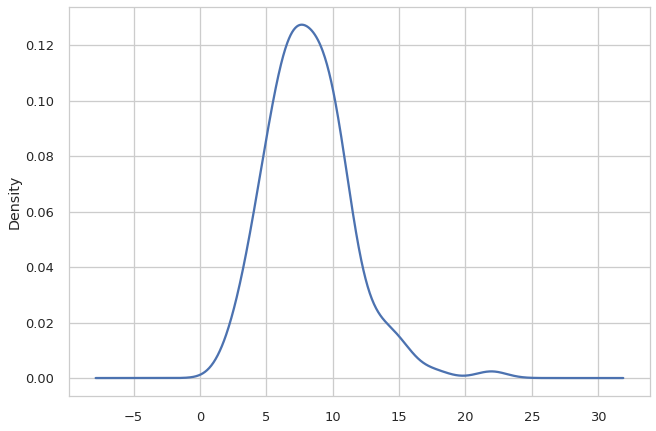

In [109]:
duda_df_base[duda_df_base.predicted_emotion_label_PaREMO == 'fear']['mean'].plot.kde()

In [131]:
duda_df_base['mean'] = duda_df_base['mean'].apply(lambda x: np.log(x+1))

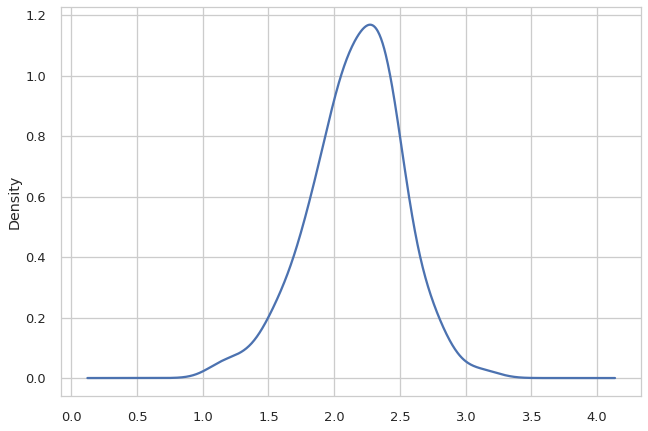

In [111]:
duda_df_base[duda_df_base.predicted_emotion_label_PaREMO == 'fear']['mean'].plot.kde()

####Biserial correlation scheme - social media response

In [38]:
schems

['scheme_name_Causal Slippery Slope',
 'scheme_name_Danger Appeal',
 'scheme_name_Fear Appeal',
 'scheme_name_Need For Help',
 'scheme_name_Negative Consequences',
 'scheme_name_Positive Consequences',
 'scheme_name_Waste']

In [ ]:
duda_df_base[schems].tail()

In [187]:
for s in schems:
  duda_df_base[s] = np.where(duda_df_base[s] > 0, 1, 0)

duda_df_base[schems].head()

,scheme_name_Causal Slippery Slope,scheme_name_Danger Appeal,scheme_name_Fear Appeal,scheme_name_Need For Help,scheme_name_Negative Consequences,scheme_name_Positive Consequences,scheme_name_Waste
21,0,0,0,0,0,1,0
22,0,0,0,0,0,1,0
23,0,0,0,0,0,1,0
24,0,0,0,0,0,1,0
25,0,0,0,0,0,1,0


####**Corr with positive sentiment**

In [178]:
corr_pos = duda_df_base[duda_df_base.sentiment_label_PaRes == 'pos']
corr_pos = corr_pos.dropna(subset = ['mean'])
corr_pos.shape

(146, 26)

In [ ]:
corr_pos[schems+['mean']].info()

In [179]:
coeffs_all = []
p_val_all = []

for s in schems:
  print(s)
  sm_response_sentiment = corr_pos['mean'].apply(float).values
  binary_scheme = corr_pos[s].apply(int).values

  coefbi, bi_p = pointbiserialr(binary_scheme, sm_response_sentiment)
  coeffs_all.append(round(coefbi, 2))
  p_val_all.append(round(bi_p, 3))

  if bi_p <= 0.05:
    print(f'{s} - coeff: {coefbi}:  {round(bi_p, 3)}')

scheme_name_Causal Slippery Slope
scheme_name_Danger Appeal
scheme_name_Fear Appeal
scheme_name_Need For Help
scheme_name_Need For Help - coeff: -0.20530193921604625:  0.013
scheme_name_Negative Consequences
scheme_name_Positive Consequences
scheme_name_Positive Consequences - coeff: -0.24807895226967178:  0.003
scheme_name_Waste


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [180]:
df_cor_bi_pos = pd.DataFrame({"scheme": schems, 
                       "cor": coeffs_all, 
                       "p_value":p_val_all})

In [157]:
df_cor_bi_pos[df_cor_bi_pos.p_value <= 0.05] # may at least 1 ann

,scheme,cor,p_value
5,scheme_name_Positive Consequences,-0.21,0.012


In [135]:
df_cor_bi_pos[df_cor_bi_pos.p_value <= 0.05] # may at least 2 ann

,scheme,cor,p_value
5,scheme_name_Positive Consequences,-0.19,0.025


In [104]:
df_cor_bi_pos[df_cor_bi_pos.p_value <= 0.05] # may at least 2 ann no log

,scheme,cor,p_value
5,scheme_name_Positive Consequences,-0.19,0.025


In [181]:
df_cor_bi_pos[df_cor_bi_pos.p_value <= 0.05] # june at least 1 ann

,scheme,cor,p_value
3,scheme_name_Need For Help,-0.21,0.013
5,scheme_name_Positive Consequences,-0.25,0.003


In [44]:
df_cor_bi_pos[df_cor_bi_pos.p_value <= 0.05] # june at least 2 ann

,scheme,cor,p_value


In [67]:
df_cor_bi_pos[df_cor_bi_pos.p_value <= 0.05] # june at least 2 ann no log

,scheme,cor,p_value


####****Corr with negative sentiment**

In [182]:
corr_neg = duda_df_base[duda_df_base.sentiment_label_PaRes == 'neg']
corr_neg = corr_neg.dropna(subset = ['mean'])

corr_neg.shape

(147, 26)

In [183]:
coeffs_all = []
p_val_all = []

for s in schems:
  print(s)
  sm_response_sentiment = corr_neg['mean'].apply(float).values
  binary_scheme = corr_neg[s].apply(int).values

  coefbi, bi_p = pointbiserialr(binary_scheme, sm_response_sentiment)
  coeffs_all.append(round(coefbi, 2))
  p_val_all.append(round(bi_p, 4))

  if bi_p <= 0.05:
    print(f'\t{s} - coeff: {coefbi}:  {round(bi_p, 4)} \t n samples {len(sm_response_sentiment)} ')

scheme_name_Causal Slippery Slope
scheme_name_Danger Appeal
scheme_name_Fear Appeal
scheme_name_Need For Help
scheme_name_Negative Consequences
scheme_name_Positive Consequences
scheme_name_Waste


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [184]:
df_cor_bi_neg = pd.DataFrame({"scheme": schems, 
                       "cor": coeffs_all, 
                       "p_value":p_val_all})

In [161]:
df_cor_bi_neg[df_cor_bi_neg.p_value <= 0.05] # may 1 anno

,scheme,cor,p_value


In [140]:
df_cor_bi_neg[df_cor_bi_neg.p_value <= 0.05] # may

,scheme,cor,p_value


In [107]:
df_cor_bi_neg[df_cor_bi_neg.p_value <= 0.05] # may at 2 ann no log

,scheme,cor,p_value


In [185]:
df_cor_bi_neg[df_cor_bi_neg.p_value <= 0.05] # june 1 anno

,scheme,cor,p_value


In [48]:
df_cor_bi_neg[df_cor_bi_neg.p_value <= 0.05] # june at least 2 an 

,scheme,cor,p_value


In [71]:
df_cor_bi_neg[df_cor_bi_neg.p_value <= 0.05] # june at least 2 an  no log

,scheme,cor,p_value


####****Corr emotions expressed**

In [ ]:
duda_df_base.predicted_emotion_label_PaREMO.unique()

array(['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise'],
      dtype=object)

In [188]:
coeffs_all = []
p_val_all = []
schems_all = []
emo_all = []

for s in schems:
  print(s)
  for e in duda_df_base.predicted_emotion_label_PaREMO.unique():
    print('\t', e)
    schems_all.append(s)
    emo_all.append(e)
    corr_emo = duda_df_base[duda_df_base.predicted_emotion_label_PaREMO == e].dropna()  
    sm_response_sentiment = corr_emo['mean'].apply(float).values
    binary_scheme = corr_emo[s].apply(int).values

    coefbi, bi_p = pointbiserialr(binary_scheme, sm_response_sentiment)
    coeffs_all.append(round(coefbi, 2))
    p_val_all.append(round(bi_p, 4))

    if bi_p <= 0.05:
      print(f'{s} - {e} \t coeff: {coefbi}:  {round(bi_p, 4)}\t n samples: {len(binary_scheme)} ')

scheme_name_Causal Slippery Slope
	 anger
	 disgust
	 fear
	 joy
	 sadness
scheme_name_Causal Slippery Slope - sadness 	 coeff: 0.2915372159839767:  0.0106	 n samples: 76 
	 surprise
scheme_name_Danger Appeal
	 anger
scheme_name_Danger Appeal - anger 	 coeff: -0.26509974787303964:  0.0206	 n samples: 76 
	 disgust
	 fear
	 joy
	 sadness
	 surprise
scheme_name_Fear Appeal
	 anger
	 disgust
	 fear
	 joy
	 sadness
	 surprise
scheme_name_Need For Help
	 anger
scheme_name_Need For Help - anger 	 coeff: -0.27076703718028117:  0.018	 n samples: 76 
	 disgust
	 fear
	 joy
	 sadness
	 surprise
scheme_name_Negative Consequences
	 anger
	 disgust
	 fear
	 joy
	 sadness
	 surprise
scheme_name_Positive Consequences
	 anger
	 disgust
	 fear
	 joy
	 sadness
	 surprise
scheme_name_Waste
	 anger
	 disgust
	 fear
	 joy
	 

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


sadness
	 surprise


In [189]:
df_cor_bi_emo = pd.DataFrame({"scheme": schems_all, 'emotion_response_sm': emo_all, 
                       "cor": coeffs_all, 
                       "p_value":p_val_all})

In [149]:
df_cor_bi_emo[df_cor_bi_emo.p_value <= 0.05] # may at least 1 ann

,scheme,emotion_response_sm,cor,p_value
14,scheme_name_Fear Appeal,fear,0.26,0.0281
30,scheme_name_Positive Consequences,anger,-0.30,0.0115
32,scheme_name_Positive Consequences,fear,0.27,0.0255


In [115]:
df_cor_bi_emo[df_cor_bi_emo.p_value <= 0.05] # may at least 2 ann

,scheme,emotion_response_sm,cor,p_value
32,scheme_name_Positive Consequences,fear,0.29,0.014


In [120]:
df_cor_bi_emo[df_cor_bi_emo.p_value <= 0.05] # may at least 2 ann no log

,scheme,emotion_response_sm,cor,p_value
32,scheme_name_Positive Consequences,fear,0.29,0.0157


In [190]:
df_cor_bi_emo[df_cor_bi_emo.p_value <= 0.05] # june at least 1 ann

,scheme,emotion_response_sm,cor,p_value
4,scheme_name_Causal Slippery Slope,sadness,0.29,0.0106
6,scheme_name_Danger Appeal,anger,-0.27,0.0206
18,scheme_name_Need For Help,anger,-0.27,0.0180


In [ ]:
df_cor_bi_emo[df_cor_bi_emo.p_value <= 0.05] # june at least 2 ann

,scheme,emotion_response_sm,cor,p_value
18,scheme_name_Need For Help,anger,-0.34,0.0025


In [61]:
df_cor_bi_emo[df_cor_bi_emo.p_value <= 0.05] # june at least 2 ann no log

,scheme,emotion_response_sm,cor,p_value
18,scheme_name_Need For Help,anger,-0.29,0.0097
